In [41]:
import matplotlib.pyplot as plt 
import numpy as np
import glob
import pandas as pd
from tqdm import tqdm

In [51]:
def process_df(signal_path: str, is_noise = False) -> pd.DataFrame:

    eq_signal_files = glob.glob(f'{signal_path}/**/*.npz', recursive=True)

    path_name = "earthquake"
    if is_noise:
        path_name = "noise"

    data = []
    for eq_path in tqdm(eq_signal_files):
        eq = np.load(eq_path, allow_pickle=True)
        Z = eq[path_name + '_waveform_Z']
        N = eq[path_name +'_waveform_N']
        E = eq[path_name +'_waveform_E']
        if not is_noise:
            magnitude = eq['magnitude']
            distance = eq['distance']
            code = eq['code']
            utc_start = eq['utc_start']
            ev_pick = eq['ev_pick']
            original_components = eq['original_components'] 
            data.append({'Z': Z, 
                        'N': N, 
                        'E': E, 
                        'magnitude': magnitude,
                        'distance': distance,
                        'code': code,
                        'utc_start': utc_start,
                        'ev_pick': ev_pick,
                        'original_components': original_components
                        })
        else:
            utc_start = eq['utc_start']
            station = eq['station']
            data.append({'Z': Z, 
                        'N': N, 
                        'E': E,
                        'utc_start': utc_start,
                        'station': station
                        })


    df = pd.DataFrame(data)

    return df

In [39]:
def plot_fft(df_signal: pd.DataFrame, df_noise: pd.DataFrame, total: int, shuffle = False):

    # Function to compute FFT and plot
    def plot_velocity(signal, title, ax):

        n = len(signal)
        time = range(n)

        # Plot the magnitude of the FFT
        ax.plot(time, signal)
        ax.set_title(title)
        ax.set_xlabel('Time')
        ax.set_ylabel('Velocity')
    
    # Function to compute FFT and plot
    def plot_fft(signal, title, ax):
        # Compute FFT
        fft_values = np.fft.fft(signal)
        fft_magnitude = np.abs(fft_values)  # Magnitude of the FFT

        # Frequency bins (corresponding to FFT output)
        freqs = np.fft.fftfreq(len(signal))

        # Plot the magnitude of the FFT
        ax.plot(freqs, fft_magnitude)
        ax.set_title(title)
        ax.set_xlabel('Frequency')
        ax.set_ylabel('Magnitude')

    # Step 1: Create a figure with subplots
    fig, axs = plt.subplots(2 * total, 3, figsize=(15, 5 * 2 * total))

    if shuffle:
        df_signal = df_signal.sample(frac=1).reset_index(drop=True)
        df_noise = df_noise.sample(frac=1).reset_index(drop=True)

    length = 6000
    start = 2000 
    end = start + length

    # Step 2: Compute and plot FFT for each signal in 'Z', 'N', 'E'
    for i in range(total):
        # Plot for Z signal

        noise_scaling = 0.5

        signal = df_signal['Z'].iloc[i][start:end]
        signal = signal / np.max(np.abs(signal))
        noise = df_noise['Z'].iloc[i][0:length]
        noise = (noise / np.max(np.abs(noise))) * noise_scaling

        noisy_eq = signal + noise * noise_scaling

        plot_velocity(signal, f'Time domain of Z signal {i}', axs[2*i, 0])
        plot_velocity(noise, f'Time domain of Z noise {i}', axs[2*i,1])
        plot_velocity(signal + noise, f'Time domain of Z signal + noise {i}', axs[2*i,2])

        plot_fft(signal, f'FFT domain of Z signal {i}', axs[2*i+1, 0])
        plot_fft(noise, f'FFT domain of Z noise {i}', axs[2*i+1, 1])
        plot_fft(noisy_eq, f'FFT domain of Z signal + noise {i}', axs[2*i+1, 2])

        y_lim = axs[2*i+1, 0].get_ylim()
        axs[2*i,1].set_ylim((-1,1))
        axs[2*i+1,1].set_ylim(y_lim)
        axs[2*i+1,2].set_ylim(y_lim)
        

    # Step 3: Display the plots
    plt.tight_layout()
    plt.show()

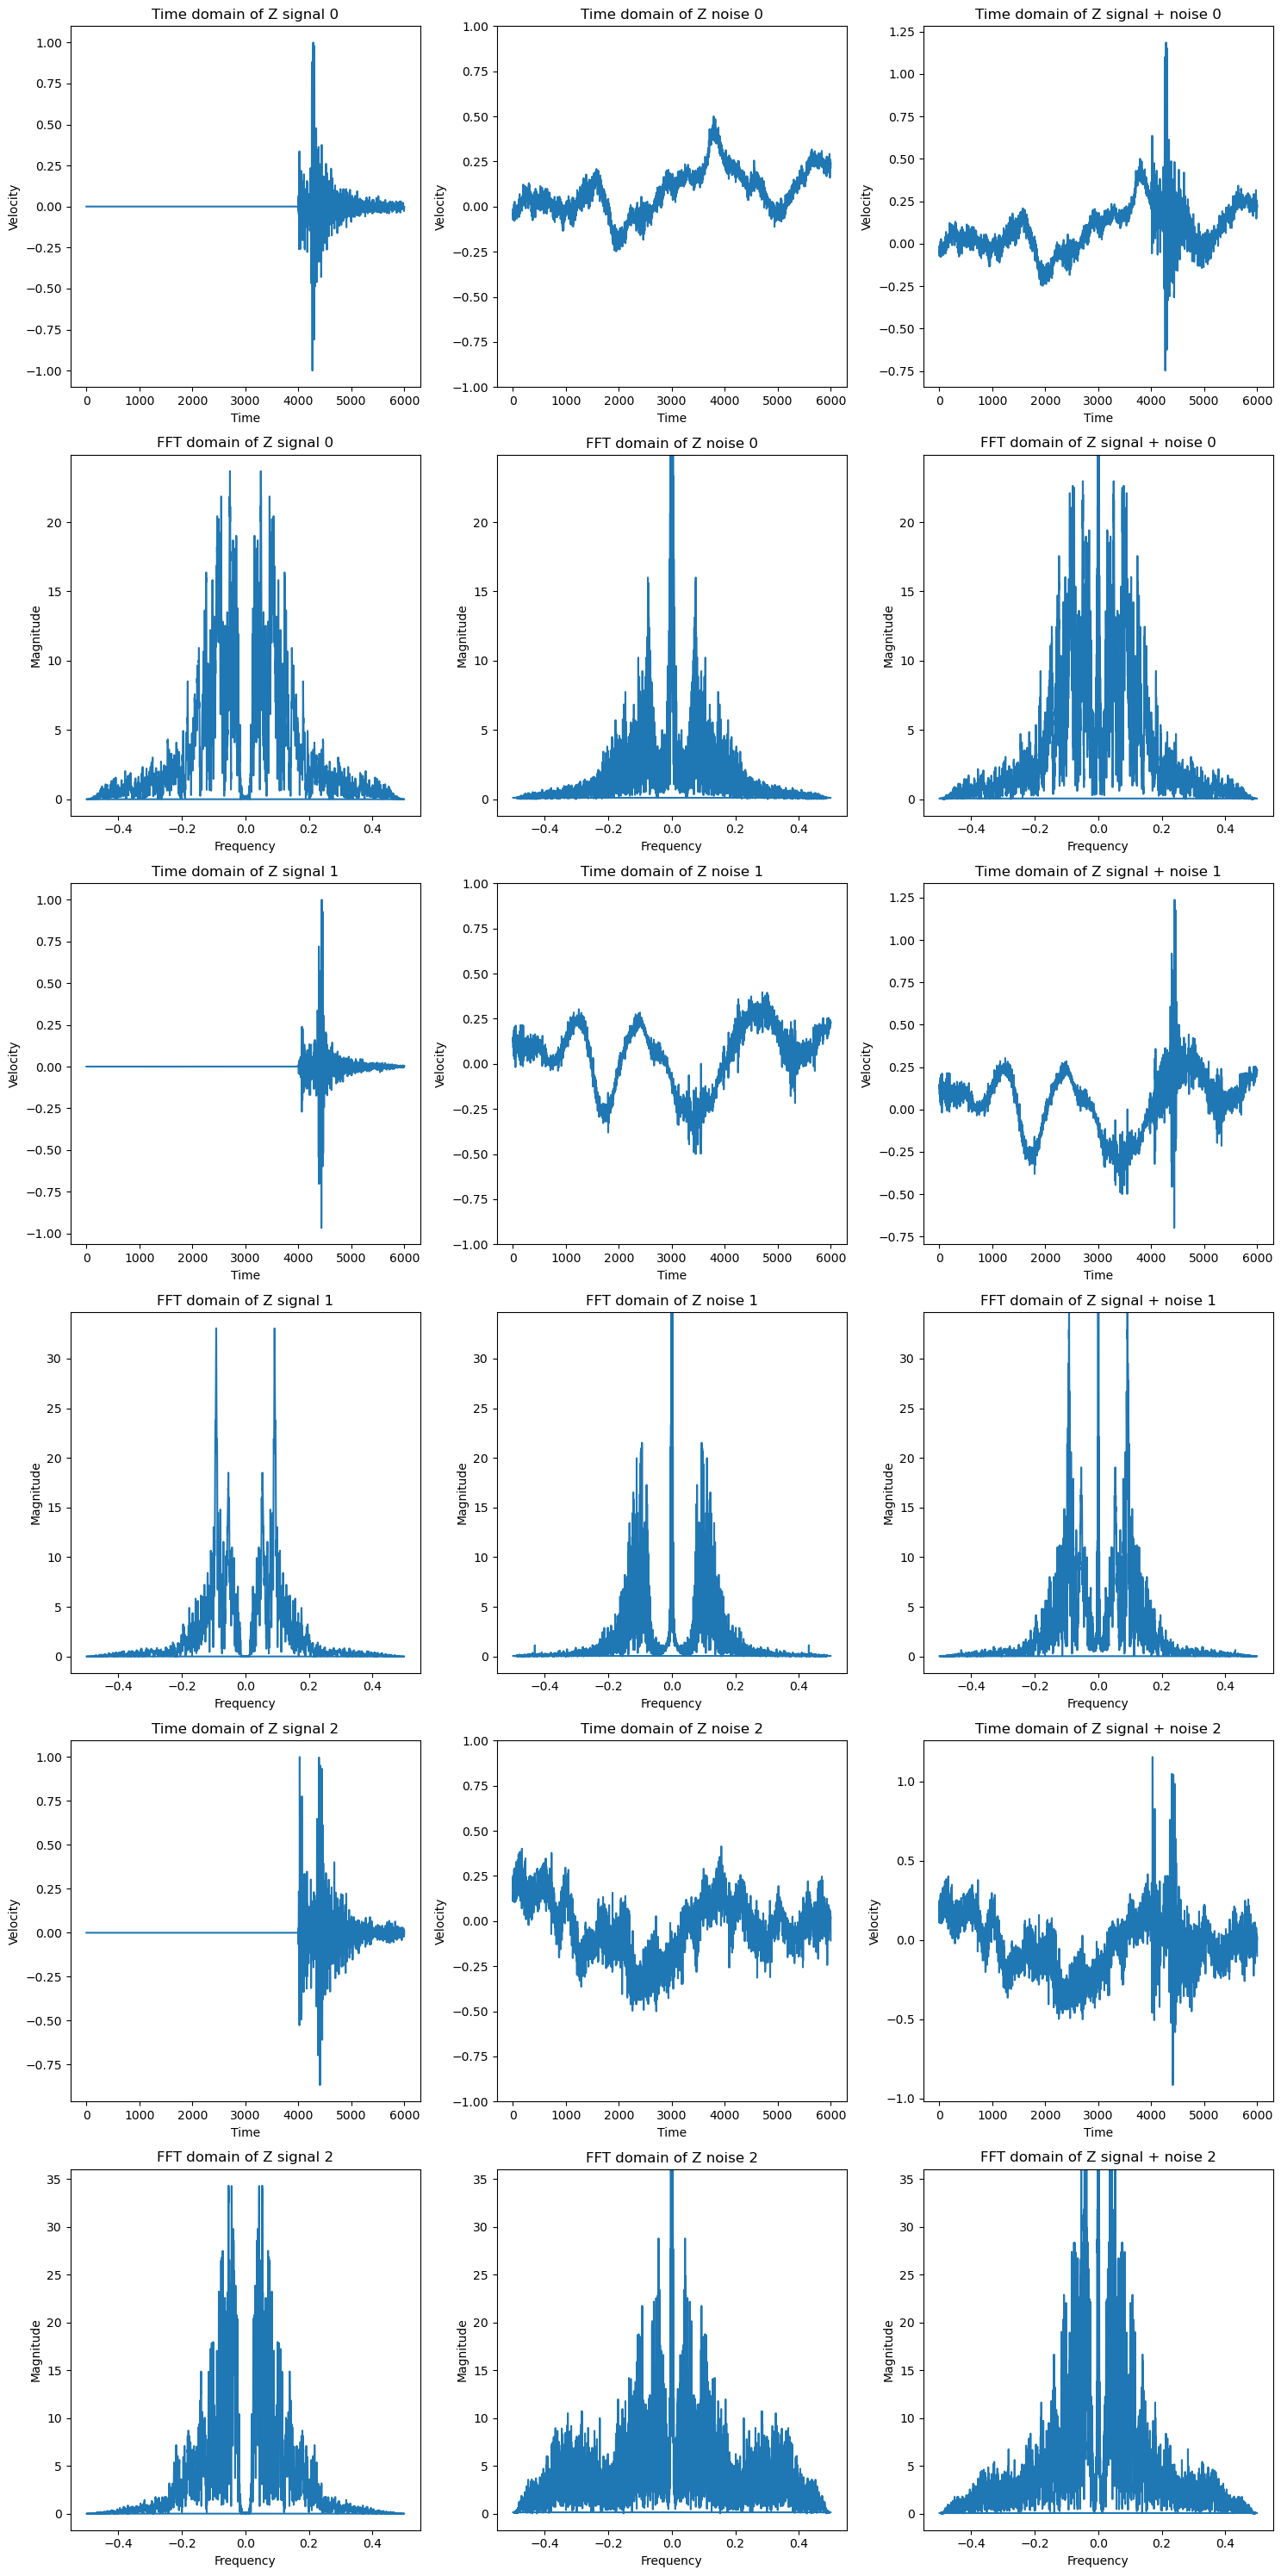

In [40]:
plot_fft(df_signal, df_noise, 3, True)